# Binary Node Classification based on Twitch Social Network Data

#### Esra Akarçay esra.akarcay@sabanciuniv.edu
#### Gizem Güneş ggunes@sabanciuniv.edu
#### Ayda Gizem Kumkumoğlu ayda.kumkumoglu@sabanciuniv.edu

These datasets used for node classification and transfer learning are Twitch user-user networks of gamers who stream in a certain language. Nodes are the users themselves and the links are mutual friendships between them. Vertex features are extracted based on the games played and liked, location and streaming habits. Datasets share the same set of node features, this makes transfer learning across networks possible. These social networks were collected in May 2018.

(http://snap.stanford.edu/data/twitch-social-networks.html )

In [220]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
from collections import Counter
import matplotlib.cm as cm
from scipy.stats import pearsonr, spearmanr, kendalltau


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import cluster as clu
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, classification_report, average_precision_score

from networkx.algorithms.link_analysis.pagerank_alg import pagerank as pagerank
from graphrole import RecursiveFeatureExtractor, RoleExtractor
from node2vec import Node2Vec
import community
from community import community_louvain
from networkx.algorithms.community import girvan_newman
from networkx.algorithms import bipartite


In [155]:
conda install .VertexPartition

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - .vertexpartition

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [4]:
data = pd.read_csv("musae_ES_edges.csv")
data.columns = ['node', 'target']
data.head()

,node,target
0,0,1819
1,0,2840
2,1,1565
3,1,1309
4,1,1397


In [126]:
G = nx.from_pandas_edgelist(data, source='node', target='target', edge_attr=None, create_using=nx.Graph())
print("Info:\n", nx.info(G), "\n")
print("Is directed: ", nx.is_directed(G))
print("Is weighted: ",nx.is_weighted(G))
print("Is bipartite", nx.is_bipartite(G))

Info:
 Name: 
Type: Graph
Number of nodes: 4648
Number of edges: 59382
Average degree:  25.5516 

Is directed:  False
Is weighted:  False
Is bipartite False


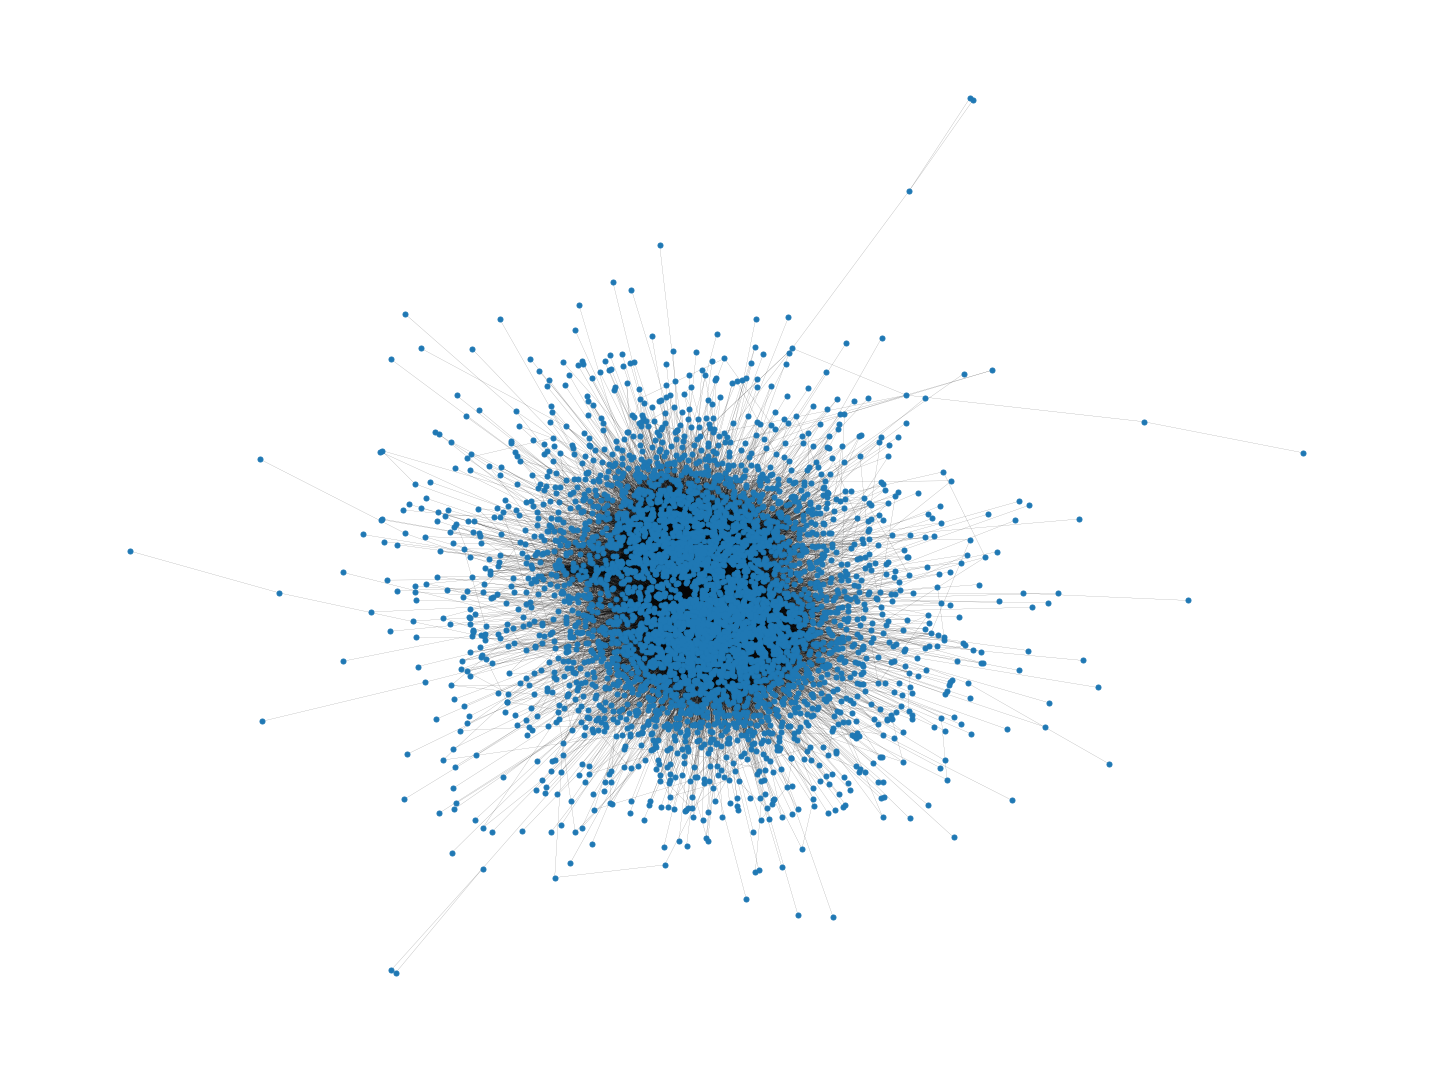

In [4]:
pos = nx.spring_layout(G, seed = 42) 
plt.figure(figsize=(20, 15))
nx.draw_networkx_nodes(G, pos, node_size=25)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
G.degree()

DegreeView({0: 2, 1819: 1022, 2840: 22, 1: 9, 1565: 595, 1309: 35, 1397: 357, 2677: 101, 3497: 3, 357: 5, 1492: 1, 4125: 20, 1351: 330, 2: 8, 1437: 12, 1728: 240, 214: 46, 485: 158, 2753: 45, 676: 4, 3719: 1012, 3: 24, 3830: 226, 2504: 72, 3387: 147, 4528: 44, 246: 56, 1266: 66, 982: 572, 596: 612, 291: 237, 2480: 299, 1676: 122, 1450: 59, 79: 125, 2112: 267, 222: 142, 2558: 157, 574: 290, 1376: 324, 2306: 262, 4642: 98, 1988: 123, 2922: 408, 896: 187, 4: 32, 2213: 44, 7: 5, 1169: 29, 963: 94, 2647: 17, 2182: 21, 1011: 8, 1264: 266, 3984: 49, 483: 145, 4397: 447, 1480: 9, 3767: 65, 1447: 6, 2771: 22, 3737: 21, 1451: 25, 1827: 90, 4423: 27, 1121: 59, 2414: 10, 4217: 34, 1067: 19, 3675: 1, 1513: 30, 4121: 51, 1083: 19, 2853: 94, 793: 79, 549: 24, 3159: 9, 5: 17, 3655: 54, 3022: 21, 570: 139, 2348: 14, 2273: 17, 4001: 69, 4228: 18, 3762: 11, 2483: 30, 111: 123, 3915: 24, 140: 30, 3128: 26, 1832: 40, 4569: 171, 1604: 25, 531: 43, 6: 3, 1047: 37, 2280: 6, 8: 6, 3235: 324, 4162: 7, 2864: 449

##  Degree Distribution

[0.         0.06303787 0.06217728 ... 0.         0.         0.00021515]


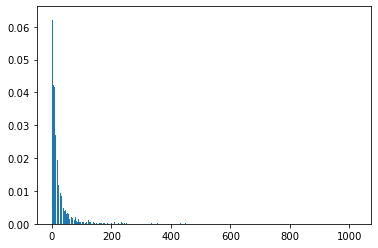

In [6]:
dhist = nx.degree_histogram(G)
# normalized histogram values
dhist = dhist / np.sum(dhist)
print(dhist)
plt.bar(range(len(dhist)), dhist)
plt.show()

Degree distribution of the network is shown above. As it can be seen from the graph as well, most of the nodes in the network has very few links while a small minority has many links. As a result, it can be inferred from the degree distribution that the network follows a Power-Law distribution

## Average Degree

In [7]:
num_edges = G.number_of_edges()
num_possible_edges = G.number_of_nodes() * (G.number_of_nodes() - 1) / 2
print(f"Number of edges present in the network: {num_edges}")
print(f"Total number of possible edges in the network: {num_possible_edges}")
print(f'The edge density is: {num_edges/num_possible_edges:.3f}')

Number of edges present in the network: 59382
Total number of possible edges in the network: 10799628.0
The edge density is: 0.005


In [8]:
degTwitch = nx.degree(G)
avgdeg = np.average(list(dict(degTwitch).values()))
print("Average Degree of the Network: {:.4f}".format(avgdeg))

Average Degree of the Network: 25.5516


## Clustering Coefficent

In [9]:
cc = nx.clustering(G)

In [10]:
ccsorted = sorted(cc.items(), key=lambda x:x[1], reverse=True)
print(ccsorted[:10])

[(0, 1.0), (16, 1.0), (37, 1.0), (4506, 1.0), (664, 1.0), (3640, 1.0), (1837, 1.0), (4524, 1.0), (154, 1.0), (4337, 1.0)]


In [11]:
# Average Clustering Coefficient
avgcc = np.average(list(cc.values()))
print(f"Average Clustering Coefficient: {avgcc:.3f}")

Average Clustering Coefficient: 0.222


## Diameter

In [12]:
# diameter of the network
print(f"diameter of the network: {nx.diameter(G)}")

diameter of the network: 9


In [13]:
# Average shortest path length
print(f"Average shortest path length of the network: {nx.average_shortest_path_length(G):.3f}")

Average shortest path length of the network: 2.883


## Connected Components

In [14]:
nx.is_connected(G)

True

In [15]:
print(nx.number_connected_components(G))

1


In [16]:
conncomp_Twitch = nx.connected_components(G)
print(list(conncomp_Twitch))

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [17]:
# The Giant Component
conncomp_und = nx.connected_components(G)
sorted_conn_comp_und = sorted(conncomp_und, key=lambda x: len(x), reverse=True)
print(sorted_conn_comp_und)
giant_conn_comp_und = sorted_conn_comp_und[0]
print(f"Giant connected component: {giant_conn_comp_und}")

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [18]:
# Size of the Giant Component
percent_giant_size = len(giant_conn_comp_und) / G.number_of_nodes()
print(f"Ratio of the size of the giant component: {percent_giant_size * 100:.2f}%")

Ratio of the size of the giant component: 100.00%


In [19]:
# Size of the Giant Component
conncomp_Twitch = nx.connected_components(G)
sorted_conn_comp_Twitch = sorted(conncomp_Twitch, key=lambda x: len(x), reverse=True)
print(sorted_conn_comp_Twitch)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

## Centrality Metrics

In [20]:
deg_cent = nx.degree_centrality(G)
print(deg_cent)

{0: 0.00043038519474930065, 1819: 0.21992683451689263, 2840: 0.004734237142242307, 1: 0.001936733376371853, 1565: 0.12803959543791693, 1309: 0.0075317409081127615, 1397: 0.07682375726275016, 2677: 0.02173445233483968, 3497: 0.000645577792123951, 357: 0.0010759629868732517, 1492: 0.00021519259737465033, 4125: 0.004303851947493007, 1351: 0.07101355713363461, 2: 0.0017215407789972026, 1437: 0.002582311168495804, 1728: 0.051646223369916075, 214: 0.009898859479233914, 485: 0.03400043038519475, 2753: 0.009683666881859265, 676: 0.0008607703894986013, 3719: 0.21777490854314613, 3: 0.005164622336991608, 3830: 0.04863352700667097, 2504: 0.015493867010974823, 3387: 0.0316333118140736, 4528: 0.009468474284484614, 246: 0.012050785452980418, 1266: 0.014202711426726921, 982: 0.12309016569829999, 596: 0.131697869593286, 291: 0.051000645577792124, 2480: 0.06434258661502044, 1676: 0.02625349687970734, 1450: 0.01269636324510437, 79: 0.02689907467183129, 2112: 0.057456423499031635, 222: 0.0305573488272003

In [21]:
np.max(list(dict(G.degree()).values()))

1022

In [22]:
s = 1.0 / (len(G) - 1.0) # normalization constant

In [23]:
s * nx.degree(G, 1022) # degree cent of node 1022

0.0015063481816225523

In [24]:
cls_cent = nx.closeness_centrality(G)
cls_cent_sorted = sorted(cls_cent.items(), key=lambda x: x[1], reverse=True)
print(cls_cent_sorted[-4:])

[(1046, 0.1775833078569245), (1743, 0.16380556240967253), (2843, 0.16380556240967253), (797, 0.15080807425196338)]


In [25]:
def compute_centralities(G, k=5, doprint=True):
    deg_cent = nx.degree_centrality(G)
    deg_cent_sorted = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)

    cls_cent = nx.closeness_centrality(G)
    cls_cent_sorted = sorted(cls_cent.items(), key=lambda x: x[1], reverse=True)

    btw_cent = nx.betweenness_centrality(G)
    btw_cent_sorted = sorted(btw_cent.items(), key=lambda x: x[1], reverse=True)

    eig_cent = nx.eigenvector_centrality(G)
    eig_cent_sorted = sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)

    katz_cent = nx.katz_centrality_numpy(G) # !! numpy
    katz_cent_sorted = sorted(katz_cent.items(), key=lambda x: x[1], reverse=True)

    pr_cent = nx.pagerank(G)
    pr_cent_sorted = sorted(pr_cent.items(), key=lambda x: x[1], reverse=True)

    hits_cent = nx.hits(G)
    hub_scr, auth_scr = hits_cent
    hub_scr_sorted = sorted(hub_scr.items(), key=lambda x: x[1], reverse=True)
    auth_scr_sorted = sorted(auth_scr.items(), key=lambda x: x[1], reverse=True)

    if doprint:
        print("      Top " + str(k) + " Centrality and PageRank/HITS scores")
        print("-----------------------------------------------------")

        print("Degree Centrality")
        for node, score in deg_cent_sorted[:k]:
            print(str(node) + ": {:.4f}".format(score), end =" ")

        print("\nEigenvector Centrality")
        for node, score in eig_cent_sorted[:k]:
            print(str(node) + ": {:.4f}".format(score), end =" ")

        print("\nKatz Centrality")
        for node, score in katz_cent_sorted[:k]:
            print(str(node) + ": {:.4f}".format(score), end =" ")

        print("\nCloseness Centrality")
        for node, score in cls_cent_sorted[:k]:
            print(str(node) + ": {:.4f}".format(score), end =" ")

        print("\nBetweenness Centrality")
        for node, score in btw_cent_sorted[:k]:
            print(str(node) + ": {:.4f}".format(score), end =" ")

        print("\nPageRank Scores")
        for node, score in pr_cent_sorted[:k]:
            print(str(node) + ": {:.4f}".format(score), end =" ")

        print("\nHubs Scores")
        for node, score in hub_scr_sorted[:k]:
            print(str(node) + ": {:.4f}".format(score), end =" ")

        print("\nAuth Scores") 
        for node, score in auth_scr_sorted[:k]:
            print(str(node) + ": {:.4f}".format(score), end =" ")
    
    return deg_cent, cls_cent, btw_cent, eig_cent, katz_cent, pr_cent, hub_scr, auth_scr 

In [26]:
compute_centralities(G, k=5, doprint=True)

      Top 5 Centrality and PageRank/HITS scores
-----------------------------------------------------
Degree Centrality
1819: 0.2199 3719: 0.2178 2475: 0.1597 596: 0.1317 1565: 0.1280 
Eigenvector Centrality
3719: 0.1543 1819: 0.1456 2475: 0.1238 982: 0.1200 1565: 0.1157 
Katz Centrality
1540: 0.0940 872: 0.0916 4323: 0.0912 3676: 0.0877 3590: 0.0855 
Closeness Centrality
3719: 0.5175 1819: 0.5169 1565: 0.4894 2475: 0.4884 4397: 0.4828 
Betweenness Centrality
3719: 0.1111 1819: 0.1095 2475: 0.0572 1565: 0.0392 596: 0.0357 
PageRank Scores
1819: 0.0090 3719: 0.0089 2475: 0.0060 596: 0.0048 1565: 0.0046 
Hubs Scores
3719: 0.0039 1819: 0.0037 2475: 0.0032 982: 0.0031 1565: 0.0029 
Auth Scores
3719: 0.0039 1819: 0.0037 2475: 0.0032 982: 0.0031 1565: 0.0029 

({0: 0.00043038519474930065,
  1819: 0.21992683451689263,
  2840: 0.004734237142242307,
  1: 0.001936733376371853,
  1565: 0.12803959543791693,
  1309: 0.0075317409081127615,
  1397: 0.07682375726275016,
  2677: 0.02173445233483968,
  3497: 0.000645577792123951,
  357: 0.0010759629868732517,
  1492: 0.00021519259737465033,
  4125: 0.004303851947493007,
  1351: 0.07101355713363461,
  2: 0.0017215407789972026,
  1437: 0.002582311168495804,
  1728: 0.051646223369916075,
  214: 0.009898859479233914,
  485: 0.03400043038519475,
  2753: 0.009683666881859265,
  676: 0.0008607703894986013,
  3719: 0.21777490854314613,
  3: 0.005164622336991608,
  3830: 0.04863352700667097,
  2504: 0.015493867010974823,
  3387: 0.0316333118140736,
  4528: 0.009468474284484614,
  246: 0.012050785452980418,
  1266: 0.014202711426726921,
  982: 0.12309016569829999,
  596: 0.131697869593286,
  291: 0.051000645577792124,
  2480: 0.06434258661502044,
  1676: 0.02625349687970734,
  1450: 0.01269636324510437,
  79: 0.0

## Pearson, Spearman Rank (Spearman's rho), Kendall Tau Correlation Coefficients

In [29]:
# list of centrality values
deg_cent, cls_cent, btw_cent, eig_cent, katz_cent, pr_cent, hub_scr, auth_scr  = compute_centralities(G, doprint=False)
centralities = {'Degree': list(deg_cent.values()), 'Eigenvector':list(eig_cent.values()), 'Katz':list(katz_cent.values()), 
                'Closeness':list(cls_cent.values()), 'Betweenness':list(btw_cent.values()), 'PageRank':list(pr_cent.values()),
                'Hubs':list(hub_scr.values()), 'Authorities':list(auth_scr.values())}

In [30]:
PCCs, SRCCs, SRPVALs, KTCCs, KTPVALs = [], [], [], [], []
for cent1, values1 in centralities.items():
    pccssub, srccsub, sppvalsub, ktsub, ktpvalsub = [], [], [], [], []
    for cent2, values2 in centralities.items():
        corr, _ = pearsonr(values1, values2)
        spear, sr_pval = spearmanr(values1, values2)
        kenltau, kt_pval = kendalltau(values1, values2)
        pccssub.append(corr)
        srccsub.append(spear)
        sppvalsub.append(sr_pval)
        ktsub.append(kenltau)
        ktpvalsub.append(kt_pval)
    PCCs.append(pccssub)
    SRCCs.append(srccsub)
    SRPVALs.append(sppvalsub)
    KTCCs.append(ktsub)
    KTPVALs.append(ktpvalsub)

dfpccs = pd.DataFrame(PCCs, columns=centralities.keys(), index=centralities.keys())
dfsrccs = pd.DataFrame(SRCCs, columns=centralities.keys(), index=centralities.keys())
dfsrpvals = pd.DataFrame(SRPVALs, columns=centralities.keys(), index=centralities.keys())
dfktccs = pd.DataFrame(KTCCs, columns=centralities.keys(), index=centralities.keys())
dfktpvals = pd.DataFrame(KTPVALs, columns=centralities.keys(), index=centralities.keys())

In [31]:
dfpccs

,Degree,Eigenvector,Katz,Closeness,Betweenness,PageRank,Hubs,Authorities
Degree,1.000000,0.916938,-0.025917,0.536972,0.793495,0.992653,0.916950,0.916950
Eigenvector,0.916938,1.000000,-0.035278,0.710473,0.594659,0.874081,1.000000,1.000000
Katz,-0.025917,-0.035278,1.000000,-0.040201,-0.026178,-0.022600,-0.035277,-0.035277
Closeness,0.536972,0.710473,-0.040201,1.000000,0.261834,0.496338,0.710463,0.710463
Betweenness,0.793495,0.594659,-0.026178,0.261834,1.000000,0.847006,0.594684,0.594684
PageRank,0.992653,0.874081,-0.022600,0.496338,0.847006,1.000000,0.874097,0.874097
Hubs,0.916950,1.000000,-0.035277,0.710463,0.594684,0.874097,1.000000,1.000000
Authorities,0.916950,1.000000,-0.035277,0.710463,0.594684,0.874097,1.000000,1.000000


In [32]:
df = pd.DataFrame(zip(1.0 / np.array(list(deg_cent.values())), list(deg_cent.values()), list(eig_cent.values()), list(katz_cent.values()), list(cls_cent.values()), 
                   list(btw_cent.values()), list(pr_cent.values()), list(hub_scr.values()), list(auth_scr.values())), 
                  columns=['InvDegree', 'Degree', 'Eigenvector', 'Katz', 'Closeness', 'Betw.', 'PageRank', 'Hub', 'Authority'],
                 index=list(deg_cent.keys()))
pdPCC = df.corr(method='pearson')
pdSRCC = df.corr(method='spearman')
pdKTCC = df.corr(method='kendall')

In [33]:
pdPCC

,InvDegree,Degree,Eigenvector,Katz,Closeness,Betw.,PageRank,Hub,Authority
InvDegree,1.000000,-0.295880,-0.383252,0.015556,-0.709469,-0.093566,-0.272178,-0.383240,-0.383240
Degree,-0.295880,1.000000,0.916938,-0.025917,0.536972,0.793495,0.992653,0.916950,0.916950
Eigenvector,-0.383252,0.916938,1.000000,-0.035278,0.710473,0.594659,0.874081,1.000000,1.000000
Katz,0.015556,-0.025917,-0.035278,1.000000,-0.040201,-0.026178,-0.022600,-0.035277,-0.035277
Closeness,-0.709469,0.536972,0.710473,-0.040201,1.000000,0.261834,0.496338,0.710463,0.710463
Betw.,-0.093566,0.793495,0.594659,-0.026178,0.261834,1.000000,0.847006,0.594684,0.594684
PageRank,-0.272178,0.992653,0.874081,-0.022600,0.496338,0.847006,1.000000,0.874097,0.874097
Hub,-0.383240,0.916950,1.000000,-0.035277,0.710463,0.594684,0.874097,1.000000,1.000000
Authority,-0.383240,0.916950,1.000000,-0.035277,0.710463,0.594684,0.874097,1.000000,1.000000


In [34]:
pip install graphrole

     |████████████████████████████████| 65 kB 584 kB/s eta 0:00:01
     |████████████████████████████████| 29.1 MB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 15.6 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 6.8 MB/s eta 0:00:01     |████████████████████████████▊   | 9.2 MB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 7.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.0
    Uninstalling decorator-5.1.0:
      Successfully uninstalled decorator-5.1.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully

In [31]:
# Local Features
def get_local_features(G):
    if G.is_directed():
        return pd.DataFrame(
                {
                    'in_degree': dict(G.in_degree(weight='weight')),
                    'out_degree': dict(G.out_degree(weight='weight')),
                    'total_degree': dict(G.degree(weight='weight')),
                }
            )

    return pd.DataFrame.from_dict(
        dict(G.degree(weight='weight')),
        orient='index',
        columns=['degree'])

In [32]:
get_local_features(G)

,degree
0,2
1819,1022
2840,22
1,9
1565,595
...,...
4086,1
4087,1
4136,2
3977,1


In [38]:
def get_edge_sum(edges):
    edgesum = sum(G.get_edge_data(*edge, default={}).get('weight', 1) for edge in edges)
    return edgesum

def get_egonet_features(G, nodelist):
    egonet_features = {}
    for node in nodelist:
        ego = nx.ego_graph(G, node, radius=1)
        ego_boundary = list(nx.edge_boundary(G, ego.nodes))
        egonet_features[node] = {
                'internal_edges': get_edge_sum(ego.edges),
                'external_edges': get_edge_sum(ego_boundary)
        }
    return egonet_features

In [39]:
nodelist = [1819, 0]
egonet_features = get_egonet_features(G, nodelist)
print(egonet_features)

{1819: {'internal_edges': 6738, 'external_edges': 21534}, 0: {'internal_edges': 3, 'external_edges': 1040}}


In [40]:
# Check Ego net of a given node
def get_egonet_feat_node(G, node):
    ego = nx.ego_graph(G, node, radius=1)
    intedges, extedges = [], []
    neighnodelist = list(ego.nodes())
    neighnodelist.remove(node)
    # get ego_net degrees
    degrees = list(dict(G.degree(neighnodelist)).values())
    
    # get ego_net features
    neigh_ego_feats_all = get_egonet_features(G, neighnodelist)
    #print(neigh_ego_feats_all)
    for neighnode, neigh_ego_feats in neigh_ego_feats_all.items():
        intedges.append(neigh_ego_feats['internal_edges'])
        extedges.append(neigh_ego_feats['external_edges'])

    #print('egonet(sum)', np.sum(intedges), np.sum(extedges))
    #print('egonet(avg)', np.mean(intedges), np.mean(extedges))
    return intedges, extedges, degrees

In [41]:
inted, exted, deg = get_egonet_feat_node(G, 1819)
print(inted)
print(exted)
print(deg)

[3, 101, 41, 12, 12, 289, 29, 23, 55, 14, 41, 37, 15, 242, 59, 3, 10, 928, 52, 74, 36, 4, 154, 131, 99, 35, 22, 73, 5, 44, 68, 3264, 513, 23, 313, 40, 38, 30, 353, 6, 26, 216, 3, 28, 146, 29, 941, 644, 348, 23, 122, 19, 666, 21, 35, 20, 8, 847, 6, 81, 19, 2, 1160, 10, 116, 1341, 30, 9, 2000, 7, 23, 11, 2, 24, 107, 36, 88, 25, 239, 24, 314, 143, 34, 36, 63, 161, 43, 10, 13, 14, 15, 173, 195, 117, 82, 31, 8, 27, 66, 187, 60, 39, 62, 206, 8, 157, 20, 361, 31, 38, 19, 6, 97, 789, 43, 347, 179, 13, 117, 96, 36, 8, 2, 10, 3, 54, 3, 208, 16, 662, 776, 1, 56, 10, 15, 9, 7, 6, 5, 13, 1431, 13, 300, 15, 266, 8, 22, 12, 6, 25, 325, 3, 92, 18, 1230, 1318, 240, 138, 170, 72, 222, 186, 6, 46, 26, 11, 197, 11, 154, 299, 70, 14, 2590, 15, 9, 420, 44, 55, 16, 25, 139, 54, 36, 32, 36, 104, 57, 644, 68, 27, 6, 16, 516, 42, 48, 12, 1573, 14, 21, 53, 12, 2708, 7, 703, 164, 90, 220, 332, 21, 22, 42, 16, 34, 16, 116, 47, 22, 272, 31, 18, 16, 28, 66, 267, 346, 31, 13, 674, 39, 5, 58, 20, 63, 115, 558, 516, 42

In [42]:
# generate egonet related recursive features
def get_egonet_recursive_features(G, nodelist=None, steps=2):
    recursive_feats = {}
    rec_feat_dict = {}
    
    if nodelist == None:
        nodelist = list(G.nodes())
    if steps < 1:
        print("No recursive features computed")
    
    sumstr, meanstr = '(sum)', '(mean)'
    intedstr, extedstr, degstr = 'int', 'ext', 'deg'
    prevcolsum, prevcolmean = sumstr, meanstr
    columns = [degstr+sumstr, intedstr+sumstr, extedstr+sumstr, degstr+meanstr, intedstr+meanstr, extedstr+meanstr]
    for node in nodelist:
        inted, exted, deg = get_egonet_feat_node(G, node)
        recursive_feats[node] = [np.sum(deg), np.sum(inted), np.sum(exted), np.mean(deg), np.mean(inted), np.mean(exted)]
        rec_feat_dict[node] = {degstr+prevcolsum:np.sum(deg), intedstr+prevcolsum:np.sum(inted), 
                               extedstr+prevcolsum:np.sum(exted), degstr+prevcolmean:np.mean(deg)
                              , intedstr+prevcolmean:np.mean(inted), extedstr+prevcolmean:np.mean(exted)}
    #print(steps)
    #print(rec_feat_dict[0]['int(sum)'])
    for step in range(2, steps+1):
        currcolsum = prevcolsum + sumstr
        currcolmean = prevcolmean + meanstr
        for node in nodelist:
            ego = nx.ego_graph(G, node, radius=1)
            intsum, extsum, intmean, extmean, degsum, degmean = [], [], [], [], [], []
            neighnodelist = list(ego.nodes())
            neighnodelist.remove(node)
            for nnode in neighnodelist:
                #print(rec_feat_dict[nnode])
                degsum.append(rec_feat_dict[nnode][degstr+prevcolsum])
                intsum.append(rec_feat_dict[nnode][intedstr+prevcolsum])
                extsum.append(rec_feat_dict[nnode][extedstr+prevcolsum])
                degmean.append(rec_feat_dict[nnode][degstr+prevcolmean])
                intmean.append(rec_feat_dict[nnode][intedstr+prevcolmean])
                extmean.append(rec_feat_dict[nnode][extedstr+prevcolmean])

            recursive_feats[node].extend([np.sum(degsum), np.sum(intsum), np.sum(extsum), 
                                          np.mean(degmean), np.mean(intmean), np.mean(extmean)])
            rec_feat_dict[node][degstr+currcolsum] = np.sum(degsum)
            rec_feat_dict[node][intedstr+currcolsum] = np.sum(intsum)
            rec_feat_dict[node][extedstr+currcolsum] = np.sum(extsum)
            rec_feat_dict[node][degstr+currcolmean] = np.mean(degmean)
            rec_feat_dict[node][intedstr+currcolmean] = np.mean(intmean)
            rec_feat_dict[node][extedstr+currcolmean] = np.mean(extmean)

        columns.extend([degstr+currcolsum, intedstr+currcolsum, extedstr+currcolsum, 
                        degstr+currcolmean, intedstr+currcolmean, extedstr+currcolmean])
        prevcolsum = currcolsum
        prevcolmean = currcolmean
    
    df_recfeat = pd.DataFrame(recursive_feats.values(), columns=columns, index=recursive_feats.keys())
    return recursive_feats, df_recfeat

In [47]:
egof, df_f = get_egonet_recursive_features(G)
print(df_f)

      deg(sum)  int(sum)  ext(sum)   deg(mean)    int(mean)     ext(mean)  \
0         1044      6786     26776  522.000000  3393.000000  13388.000000   
1819     33988    220894   4814600   33.256360   216.138943   4710.958904   
2840      5316     30270    193061  241.636364  1375.909091   8775.500000   
1         1447     12016     64327  160.777778  1335.111111   7147.444444   
1565     31716    240071   3290625   53.304202   403.480672   5530.462185   
...        ...       ...       ...         ...          ...           ...   
4086        94       720     10671   94.000000   720.000000  10671.000000   
4087        36        74      1635   36.000000    74.000000   1635.000000   
4136       149      1966     10294   74.500000   983.000000   5147.000000   
3977        36        74      1635   36.000000    74.000000   1635.000000   
4347         2         2        43    2.000000     2.000000     43.000000   

      deg(sum)(sum)  int(sum)(sum)  ext(sum)(sum)  deg(mean)(mean)  \
0    

## RolX

In [28]:
feature_extractor = RecursiveFeatureExtractor(G, max_generations=10)
features = feature_extractor.extract_features()

print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
print(features.shape, features.columns)


Features extracted from 7 recursive generations:
(4648, 21) Index(['degree(mean)(mean)(mean)(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)(mean)(mean)(mean)',
       'degree(mean)(mean)(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)(mean)(mean)',
       'degree(mean)(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)(mean)', 'degree(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)', 'internal_edges(mean)(mean)(mean)',
       'degree(mean)(mean)', 'external_edges(mean)(mean)',
       'internal_edges(mean)(mean)', 'degree(mean)', 'degree(sum)',
       'external_edges(mean)', 'external_edges(sum)', 'internal_edges(mean)',
       'internal_edges(sum)', 'degree', 'external_edges', 'internal_edges'],
      dtype='object')


In [29]:
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles

In [50]:
numroles = Counter(node_roles.values())
print('\nThere are {} distinct roles in the network'.format(len(numroles)))
print('\nRoles Distribution:')
for k, v in numroles.items():
    print('Number of Nodes in {}: {}'.format(k, v))


There are 6 distinct roles in the network

Roles Distribution:
Number of Nodes in role_4: 210
Number of Nodes in role_5: 958
Number of Nodes in role_0: 3158
Number of Nodes in role_6: 85
Number of Nodes in role_1: 161
Number of Nodes in role_2: 76


In [51]:
print('\nNode role assignments:')
pprint(node_roles)

print('\nNode role membership by percentage:')
print(role_extractor.role_percentage.round(2))


Node role assignments:
{0: 'role_4',
 1: 'role_5',
 2: 'role_0',
 3: 'role_0',
 4: 'role_0',
 5: 'role_5',
 6: 'role_0',
 7: 'role_0',
 8: 'role_0',
 9: 'role_0',
 10: 'role_6',
 11: 'role_5',
 12: 'role_5',
 13: 'role_0',
 14: 'role_0',
 15: 'role_0',
 16: 'role_0',
 17: 'role_5',
 18: 'role_0',
 19: 'role_0',
 20: 'role_0',
 21: 'role_4',
 22: 'role_0',
 23: 'role_0',
 24: 'role_0',
 25: 'role_0',
 26: 'role_0',
 27: 'role_0',
 28: 'role_4',
 29: 'role_0',
 30: 'role_0',
 31: 'role_0',
 32: 'role_4',
 33: 'role_5',
 34: 'role_0',
 35: 'role_5',
 36: 'role_0',
 37: 'role_0',
 38: 'role_5',
 39: 'role_0',
 40: 'role_0',
 41: 'role_5',
 42: 'role_0',
 43: 'role_5',
 44: 'role_0',
 45: 'role_5',
 46: 'role_5',
 47: 'role_0',
 48: 'role_0',
 49: 'role_4',
 50: 'role_0',
 51: 'role_0',
 52: 'role_0',
 53: 'role_0',
 54: 'role_4',
 55: 'role_0',
 56: 'role_0',
 57: 'role_0',
 58: 'role_0',
 59: 'role_5',
 60: 'role_5',
 61: 'role_5',
 62: 'role_5',
 63: 'role_5',
 64: 'role_0',
 65: 'role_

 1302: 'role_0',
 1303: 'role_0',
 1304: 'role_0',
 1305: 'role_0',
 1306: 'role_5',
 1307: 'role_4',
 1308: 'role_0',
 1309: 'role_0',
 1310: 'role_0',
 1311: 'role_0',
 1312: 'role_0',
 1313: 'role_0',
 1314: 'role_0',
 1315: 'role_0',
 1316: 'role_2',
 1317: 'role_5',
 1318: 'role_1',
 1319: 'role_5',
 1320: 'role_0',
 1321: 'role_0',
 1322: 'role_6',
 1323: 'role_0',
 1324: 'role_0',
 1325: 'role_0',
 1326: 'role_5',
 1327: 'role_0',
 1328: 'role_0',
 1329: 'role_0',
 1330: 'role_0',
 1331: 'role_0',
 1332: 'role_0',
 1333: 'role_5',
 1334: 'role_5',
 1335: 'role_0',
 1336: 'role_0',
 1337: 'role_0',
 1338: 'role_4',
 1339: 'role_0',
 1340: 'role_0',
 1341: 'role_1',
 1342: 'role_4',
 1343: 'role_0',
 1344: 'role_0',
 1345: 'role_4',
 1346: 'role_0',
 1347: 'role_0',
 1348: 'role_0',
 1349: 'role_0',
 1350: 'role_0',
 1351: 'role_1',
 1352: 'role_0',
 1353: 'role_6',
 1354: 'role_5',
 1355: 'role_0',
 1356: 'role_5',
 1357: 'role_0',
 1358: 'role_0',
 1359: 'role_0',
 1360: 'role_4

 2345: 'role_0',
 2346: 'role_5',
 2347: 'role_0',
 2348: 'role_5',
 2349: 'role_0',
 2350: 'role_0',
 2351: 'role_0',
 2352: 'role_0',
 2353: 'role_5',
 2354: 'role_4',
 2355: 'role_4',
 2356: 'role_0',
 2357: 'role_5',
 2358: 'role_5',
 2359: 'role_1',
 2360: 'role_0',
 2361: 'role_1',
 2362: 'role_0',
 2363: 'role_0',
 2364: 'role_0',
 2365: 'role_0',
 2366: 'role_5',
 2367: 'role_0',
 2368: 'role_5',
 2369: 'role_0',
 2370: 'role_0',
 2371: 'role_0',
 2372: 'role_0',
 2373: 'role_5',
 2374: 'role_0',
 2375: 'role_0',
 2376: 'role_0',
 2377: 'role_0',
 2378: 'role_0',
 2379: 'role_0',
 2380: 'role_0',
 2381: 'role_5',
 2382: 'role_5',
 2383: 'role_0',
 2384: 'role_0',
 2385: 'role_5',
 2386: 'role_5',
 2387: 'role_0',
 2388: 'role_5',
 2389: 'role_6',
 2390: 'role_0',
 2391: 'role_0',
 2392: 'role_0',
 2393: 'role_5',
 2394: 'role_0',
 2395: 'role_0',
 2396: 'role_0',
 2397: 'role_2',
 2398: 'role_0',
 2399: 'role_0',
 2400: 'role_0',
 2401: 'role_0',
 2402: 'role_4',
 2403: 'role_0

 3595: 'role_2',
 3596: 'role_0',
 3597: 'role_0',
 3598: 'role_0',
 3599: 'role_0',
 3600: 'role_0',
 3601: 'role_0',
 3602: 'role_0',
 3603: 'role_4',
 3604: 'role_0',
 3605: 'role_0',
 3606: 'role_5',
 3607: 'role_0',
 3608: 'role_4',
 3609: 'role_0',
 3610: 'role_0',
 3611: 'role_0',
 3612: 'role_0',
 3613: 'role_0',
 3614: 'role_1',
 3615: 'role_1',
 3616: 'role_0',
 3617: 'role_0',
 3618: 'role_5',
 3619: 'role_0',
 3620: 'role_0',
 3621: 'role_1',
 3622: 'role_0',
 3623: 'role_0',
 3624: 'role_0',
 3625: 'role_5',
 3626: 'role_0',
 3627: 'role_0',
 3628: 'role_4',
 3629: 'role_0',
 3630: 'role_0',
 3631: 'role_0',
 3632: 'role_0',
 3633: 'role_2',
 3634: 'role_0',
 3635: 'role_5',
 3636: 'role_0',
 3637: 'role_0',
 3638: 'role_0',
 3639: 'role_0',
 3640: 'role_0',
 3641: 'role_0',
 3642: 'role_0',
 3643: 'role_0',
 3644: 'role_0',
 3645: 'role_5',
 3646: 'role_5',
 3647: 'role_0',
 3648: 'role_0',
 3649: 'role_0',
 3650: 'role_0',
 3651: 'role_0',
 3652: 'role_5',
 3653: 'role_0

      role_0  role_1  role_2  role_3  role_4  role_5  role_6
0       0.06    0.06    0.06    0.06    0.63    0.06    0.06
1       0.06    0.06    0.06    0.06    0.06    0.63    0.06
2       0.63    0.06    0.06    0.06    0.06    0.06    0.06
3       0.87    0.01    0.09    0.01    0.01    0.01    0.01
4       0.91    0.01    0.01    0.01    0.01    0.01    0.01
...      ...     ...     ...     ...     ...     ...     ...
4643    0.80    0.01    0.13    0.01    0.01    0.01    0.01
4644    0.93    0.00    0.04    0.00    0.00    0.00    0.00
4645    0.67    0.02    0.02    0.02    0.02    0.02    0.22
4646    0.03    0.03    0.03    0.03    0.03    0.84    0.03
4647    0.04    0.04    0.40    0.04    0.04    0.40    0.04

[4648 rows x 7 columns]


In [52]:
# build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
color_map = sns.color_palette('Paired', n_colors=len(unique_roles))
# map roles to colors
role_colors = {role: color_map[i] for i, role in enumerate(unique_roles)}
# build list of colors for all nodes in G
node_colors = [role_colors[node_roles[node]] for node in G.nodes]

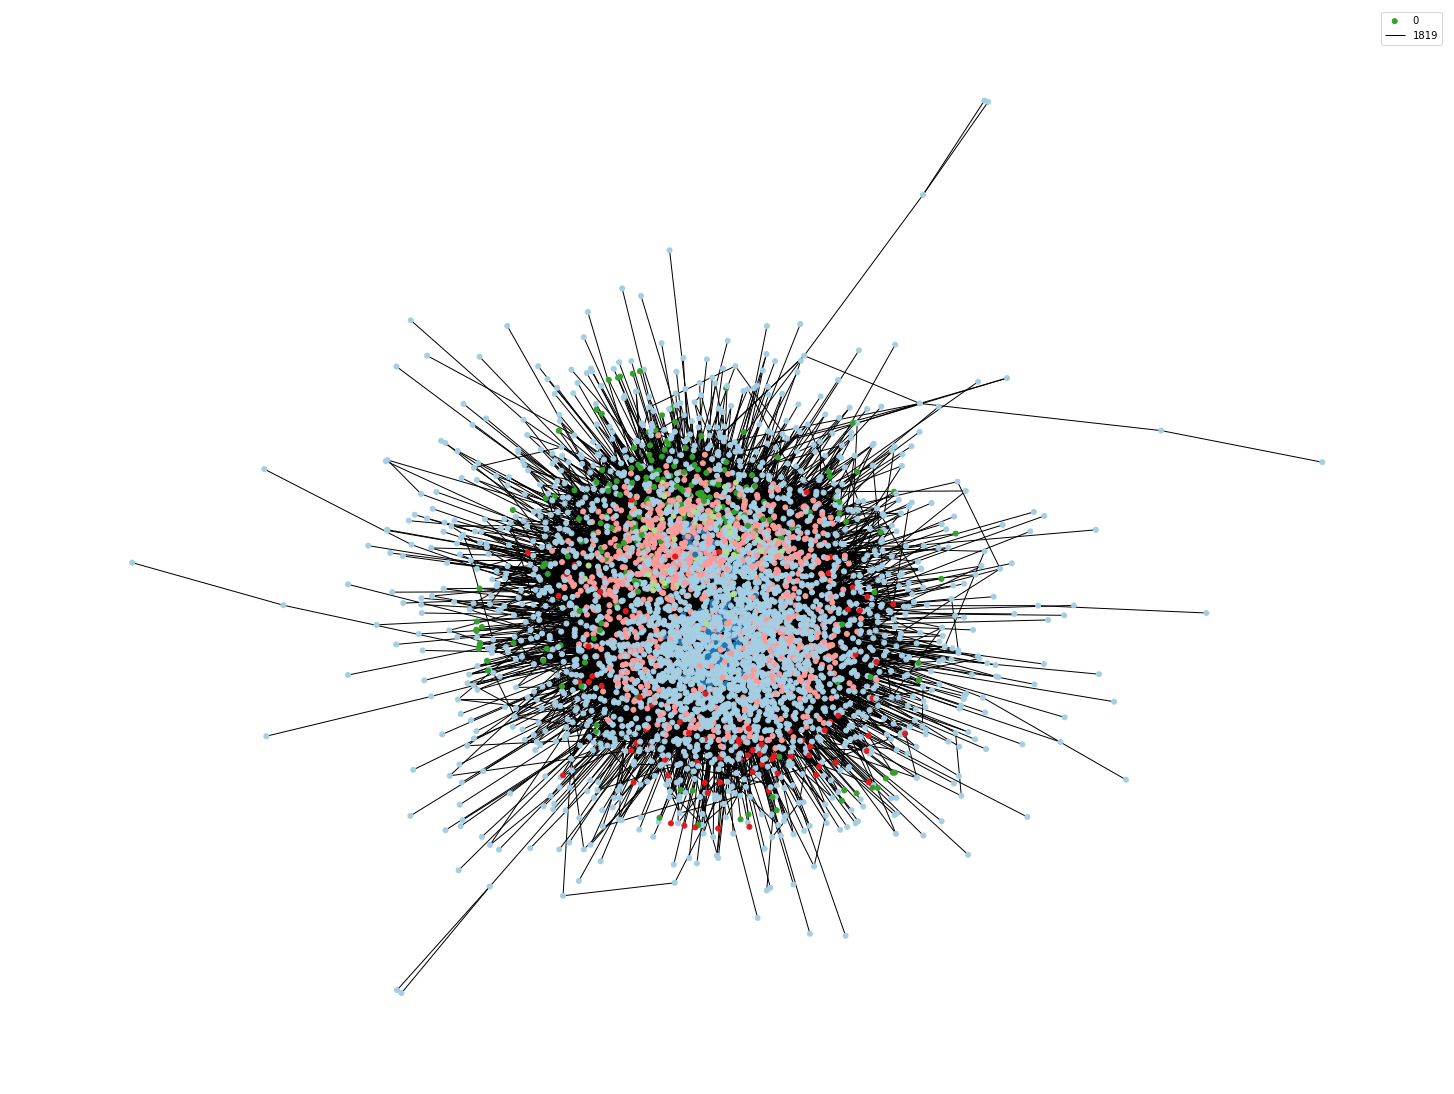

In [53]:
plt.figure(figsize=(20, 15))
import warnings
with warnings.catch_warnings():
    # catch matplotlib deprecation warning
    warnings.simplefilter('ignore')
    nx.draw(
        G,
        pos=nx.spring_layout(G, seed=42),
        node_color=node_colors,
        node_size=25
    )
# plot graph
plt.legend(G.nodes())
plt.show()

## Feature Extraction - Representation Learning

In [37]:
degCent = nx.degree_centrality(G)
eigCent = nx.eigenvector_centrality(G)
clsCent = nx.closeness_centrality(G)
btwCent = nx.betweenness_centrality(G)

In [38]:
centralityfeatures = pd.DataFrame({'degCent': degCent, 'eigCent': eigCent, 
                                   'clsCent':clsCent, 'btwCent': btwCent})

In [39]:
centralityfeatures.head()

,degCent,eigCent,clsCent,btwCent
0,0.000430,0.001739,0.344095,0.000000
1819,0.219927,0.145625,0.516850,0.109466
2840,0.004734,0.010536,0.395691,0.000184
1,0.001937,0.003347,0.348012,0.000527
1565,0.128040,0.115733,0.489364,0.039242


In [179]:
# extract features
df_rolx_features = feature_extractor.extract_features()

print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
print(df_rolx_features.shape, df_rolx_features.columns)
df_rolx_features.head()


Features extracted from 7 recursive generations:
(4648, 21) Index(['degree(mean)(mean)(mean)(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)(mean)(mean)(mean)',
       'degree(mean)(mean)(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)(mean)(mean)',
       'degree(mean)(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)(mean)', 'degree(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)', 'internal_edges(mean)(mean)(mean)',
       'degree(mean)(mean)', 'external_edges(mean)(mean)',
       'internal_edges(mean)(mean)', 'degree(mean)', 'degree(sum)',
       'external_edges(mean)', 'external_edges(sum)', 'internal_edges(mean)',
       'internal_edges(sum)', 'degree', 'external_edges', 'internal_edges'],
      dtype='object')


,degree(mean)(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean),degree(mean)(mean)(mean),external_edges(mean)(mean)(mean),internal_edges(mean)(mean)(mean),degree(mean)(mean),...,internal_edges(mean)(mean),degree(mean),degree(sum),external_edges(mean),external_edges(sum),internal_edges(mean),internal_edges(sum),degree,external_edges,internal_edges
0,122.911817,7031.575466,132.282348,7161.562752,126.666861,7007.144222,171.968253,7613.460850,1218.033682,137.446362,...,796.024017,522.000000,1044.0,13388.000000,26776.0,3393.000000,6786.0,2,1040,3
1,117.451245,6887.160205,127.834668,7069.735537,108.328023,6606.690605,137.216901,7124.999997,1118.709990,79.521062,...,634.025197,160.777778,1447.0,7147.444444,64327.0,1335.111111,12016.0,9,1430,13
2,113.661413,6905.925289,144.803249,7465.488015,104.716202,6701.192091,180.449038,7868.899871,1310.129894,96.709424,...,669.506174,230.875000,1847.0,7066.750000,56534.0,1375.875000,11007.0,8,1831,12
3,115.806022,6963.119542,132.071738,7315.552365,107.097952,6910.196859,152.362408,7981.788553,1243.196963,83.893786,...,698.164599,246.541667,5917.0,11846.208333,284309.0,2131.750000,51162.0,24,5739,101
4,131.315295,7268.699390,109.250859,6890.940159,142.528488,7518.393904,94.558898,6709.813626,741.800976,147.995578,...,1027.830011,75.968750,2431.0,6181.906250,197821.0,616.687500,19734.0,32,2301,81


In [41]:
df_allfeats_eng = pd.concat([centralityfeatures, df_rolx_features], axis=1)
df_allfeats_eng.head()

,degCent,eigCent,clsCent,btwCent,degree(mean)(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean),...,internal_edges(mean)(mean),degree(mean),degree(sum),external_edges(mean),external_edges(sum),internal_edges(mean),internal_edges(sum),degree,external_edges,internal_edges
0,0.000430,0.001739,0.344095,0.000000,122.911817,7031.575466,132.282348,7161.562752,126.666861,7007.144222,...,796.024017,522.000000,1044.0,13388.000000,26776.0,3393.000000,6786.0,2,1040,3
1,0.001937,0.003347,0.348012,0.000527,117.451245,6887.160205,127.834668,7069.735537,108.328023,6606.690605,...,634.025197,160.777778,1447.0,7147.444444,64327.0,1335.111111,12016.0,9,1430,13
2,0.001722,0.003403,0.356556,0.000019,113.661413,6905.925289,144.803249,7465.488015,104.716202,6701.192091,...,669.506174,230.875000,1847.0,7066.750000,56534.0,1375.875000,11007.0,8,1831,12
3,0.005165,0.015781,0.400673,0.000042,115.806022,6963.119542,132.071738,7315.552365,107.097952,6910.196859,...,698.164599,246.541667,5917.0,11846.208333,284309.0,2131.750000,51162.0,24,5739,101
4,0.006886,0.007962,0.358676,0.000535,131.315295,7268.699390,109.250859,6890.940159,142.528488,7518.393904,...,1027.830011,75.968750,2431.0,6181.906250,197821.0,616.687500,19734.0,32,2301,81


## Node2vec

In [59]:
pip install Node2Vec

     |████████████████████████████████| 24.0 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 2.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [60]:
pip install node2vec

Note: you may need to restart the kernel to use updated packages.


In [62]:
pip install --upgrade numpy

     |████████████████████████████████| 17.6 MB 3.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.3 which is incompatible.
graphrole 1.0.2 requires numpy==1.19.5, but you have numpy 1.22.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [55]:
n2v = Node2Vec(G, dimensions=20, walk_length=20, 
                     num_walks=50, p=1, q=1, workers=4, weight_key=None)

Computing transition probabilities:   0%|          | 0/4648 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:17<00:00,  1.43s/it]


In [56]:
model = n2v.fit(window=10)

In [57]:
n2vrep = dict()
for node in G.nodes():
    n2vrep[node] = model.wv[str(node)]
df_n2v = pd.DataFrame(n2vrep)
df_n2v = df_n2v.T
df_n2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.038693,0.061539,-0.054123,0.108531,0.082604,0.013199,0.693135,0.822040,0.337492,-0.604159,0.508554,-0.548458,-0.920315,-0.316865,0.209545,0.205136,0.236856,0.183324,-0.473698,0.110939
1819,0.021252,-0.048278,0.307998,0.082019,0.237442,-0.169190,0.879707,0.337308,0.037778,-0.031192,0.354485,-0.300931,-0.267196,-0.403600,0.223628,0.014998,0.238747,-0.052691,-0.313206,-0.322988
2840,-0.050995,-0.099610,-0.119920,0.203510,0.119797,0.019115,0.521396,0.794796,0.120367,-0.449950,0.443432,-0.600783,-0.487771,-0.208593,0.337861,0.397761,0.023262,0.153684,-0.291841,-0.012149
1,-0.288346,-0.116251,0.518327,-0.502320,0.014213,-0.713407,0.025140,0.863544,0.226216,-0.269575,0.626956,-0.681756,-0.499925,1.295646,-0.506894,0.335549,0.570367,-0.813523,-0.272436,0.134440
1565,0.397726,-0.005229,0.224576,0.115542,0.294123,0.156943,0.317848,0.466120,0.207030,0.205369,0.241921,0.043532,0.214276,0.574723,0.245252,0.404123,0.601845,-0.236635,-0.417112,0.303176


In [58]:
df_n2v.reset_index(inplace=True)
df_n2v.rename(columns={"index":"node"}, inplace=True)

In [59]:
df_n2v

,node,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,-0.038693,0.061539,-0.054123,0.108531,0.082604,0.013199,0.693135,0.822040,0.337492,...,0.508554,-0.548458,-0.920315,-0.316865,0.209545,0.205136,0.236856,0.183324,-0.473698,0.110939
1,1819,0.021252,-0.048278,0.307998,0.082019,0.237442,-0.169190,0.879707,0.337308,0.037778,...,0.354485,-0.300931,-0.267196,-0.403600,0.223628,0.014998,0.238747,-0.052691,-0.313206,-0.322988
2,2840,-0.050995,-0.099610,-0.119920,0.203510,0.119797,0.019115,0.521396,0.794796,0.120367,...,0.443432,-0.600783,-0.487771,-0.208593,0.337861,0.397761,0.023262,0.153684,-0.291841,-0.012149
3,1,-0.288346,-0.116251,0.518327,-0.502320,0.014213,-0.713407,0.025140,0.863544,0.226216,...,0.626956,-0.681756,-0.499925,1.295646,-0.506894,0.335549,0.570367,-0.813523,-0.272436,0.134440
4,1565,0.397726,-0.005229,0.224576,0.115542,0.294123,0.156943,0.317848,0.466120,0.207030,...,0.241921,0.043532,0.214276,0.574723,0.245252,0.404123,0.601845,-0.236635,-0.417112,0.303176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,4086,-0.086484,0.308005,0.505192,-0.219484,-0.077697,0.362400,-0.651440,0.936739,-0.729444,...,0.181379,0.552138,0.112440,0.189536,-0.112410,-0.439888,1.266491,-0.761138,-0.482244,0.040494
4644,4087,-0.635304,0.856153,-0.062645,-0.179462,-0.067565,-0.233664,0.095861,0.583266,0.435096,...,-0.791013,-0.567069,-0.254621,-0.878679,1.450596,0.940738,0.730490,-0.442428,-0.112636,-0.122853
4645,4136,-0.384947,0.332534,0.190161,-0.264417,-0.185855,-0.130974,-1.411163,0.268941,0.836596,...,0.789714,-0.249015,-0.826378,-0.454077,-0.177173,0.569783,0.728211,-0.349077,-0.270491,-1.311313
4646,3977,-0.543592,0.728870,-0.137308,-0.049209,0.046636,-0.534659,-0.209915,0.673901,0.251041,...,-0.782136,-0.780650,-0.267119,-1.246923,1.487637,0.749576,0.962349,-0.473954,-0.225701,0.031372


In [61]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def visualize(g, partition_g, color_choice="auto", width=1):
    if color_choice == "auto":
        pos = community_layout(g, partition_g)
        plt.figure(figsize=(20, 15))
        nx.draw(g, pos, node_color=list(partition_g.values()), node_size=15, width=list(pgrdf["pgr"].values)); plt.show()
        return
    if color_choice == "manuel":
        pos = community_layout(g, partition_g)
        plt.figure(figsize=(20, 15))
        nx.draw(g, pos, node_color=centrality_colors, node_size=15, width=list(dict(G_filtered.degree).values())); plt.show()
        return    

In [62]:
pgr = pagerank(G, weight=None)

In [66]:
df_n2v

,node,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,-0.038693,0.061539,-0.054123,0.108531,0.082604,0.013199,0.693135,0.822040,0.337492,...,0.508554,-0.548458,-0.920315,-0.316865,0.209545,0.205136,0.236856,0.183324,-0.473698,0.110939
1,1819,0.021252,-0.048278,0.307998,0.082019,0.237442,-0.169190,0.879707,0.337308,0.037778,...,0.354485,-0.300931,-0.267196,-0.403600,0.223628,0.014998,0.238747,-0.052691,-0.313206,-0.322988
2,2840,-0.050995,-0.099610,-0.119920,0.203510,0.119797,0.019115,0.521396,0.794796,0.120367,...,0.443432,-0.600783,-0.487771,-0.208593,0.337861,0.397761,0.023262,0.153684,-0.291841,-0.012149
3,1,-0.288346,-0.116251,0.518327,-0.502320,0.014213,-0.713407,0.025140,0.863544,0.226216,...,0.626956,-0.681756,-0.499925,1.295646,-0.506894,0.335549,0.570367,-0.813523,-0.272436,0.134440
4,1565,0.397726,-0.005229,0.224576,0.115542,0.294123,0.156943,0.317848,0.466120,0.207030,...,0.241921,0.043532,0.214276,0.574723,0.245252,0.404123,0.601845,-0.236635,-0.417112,0.303176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,4086,-0.086484,0.308005,0.505192,-0.219484,-0.077697,0.362400,-0.651440,0.936739,-0.729444,...,0.181379,0.552138,0.112440,0.189536,-0.112410,-0.439888,1.266491,-0.761138,-0.482244,0.040494
4644,4087,-0.635304,0.856153,-0.062645,-0.179462,-0.067565,-0.233664,0.095861,0.583266,0.435096,...,-0.791013,-0.567069,-0.254621,-0.878679,1.450596,0.940738,0.730490,-0.442428,-0.112636,-0.122853
4645,4136,-0.384947,0.332534,0.190161,-0.264417,-0.185855,-0.130974,-1.411163,0.268941,0.836596,...,0.789714,-0.249015,-0.826378,-0.454077,-0.177173,0.569783,0.728211,-0.349077,-0.270491,-1.311313
4646,3977,-0.543592,0.728870,-0.137308,-0.049209,0.046636,-0.534659,-0.209915,0.673901,0.251041,...,-0.782136,-0.780650,-0.267119,-1.246923,1.487637,0.749576,0.962349,-0.473954,-0.225701,0.031372


## Clarification of Target

In [72]:
df2= pd.read_csv("musae_ES_target.csv")

In [73]:
df2.head()

,id,days,mature,views,partner,new_id
0,68458707,1522,False,4405,False,3558
1,133928858,768,False,164810,True,3372
2,46892468,1895,False,4953,False,818
3,128745923,828,True,12262,False,236
4,84422595,1317,False,4937,False,2255


In [78]:
view_mean=df2.views.mean()

In [79]:
view_mean


103236.73257314974

In [80]:
df2['target'] = np.where(df2['views'] >= view_mean, 1, 0)
df2.head()

,id,days,mature,views,partner,new_id,target
0,68458707,1522,False,4405,False,3558,0
1,133928858,768,False,164810,True,3372,1
2,46892468,1895,False,4953,False,818,0
3,128745923,828,True,12262,False,236,0
4,84422595,1317,False,4937,False,2255,0


In [81]:
# classification would be based on avg view count, if view count is above average class would be "1" else "0".

In [83]:
merged_dfn2v = pd.merge(df_n2v, df2, left_on='node', right_on='new_id', how='left').drop("new_id", axis=1)
merged_dfn2v.head()

,node,0,1,2,3,4,5,6,7,8,...,16,17,18,19,id,days,mature,views,partner,target
0,0,-0.038693,0.061539,-0.054123,0.108531,0.082604,0.013199,0.693135,0.822040,0.337492,...,0.236856,0.183324,-0.473698,0.110939,81715208,1347,False,1925,False,0
1,1819,0.021252,-0.048278,0.307998,0.082019,0.237442,-0.169190,0.879707,0.337308,0.037778,...,0.238747,-0.052691,-0.313206,-0.322988,36138196,2221,False,18196139,True,1
2,2840,-0.050995,-0.099610,-0.119920,0.203510,0.119797,0.019115,0.521396,0.794796,0.120367,...,0.023262,0.153684,-0.291841,-0.012149,38155229,2138,False,3555,False,0
3,1,-0.288346,-0.116251,0.518327,-0.502320,0.014213,-0.713407,0.025140,0.863544,0.226216,...,0.570367,-0.813523,-0.272436,0.134440,61235209,1637,False,2350,False,0
4,1565,0.397726,-0.005229,0.224576,0.115542,0.294123,0.156943,0.317848,0.466120,0.207030,...,0.601845,-0.236635,-0.417112,0.303176,47939440,1877,False,9362112,True,1


In [84]:
merged_dfn2v.drop("views",inplace=True, axis=1)
merged_dfn2v.head()

,node,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,id,days,mature,partner,target
0,0,-0.038693,0.061539,-0.054123,0.108531,0.082604,0.013199,0.693135,0.822040,0.337492,...,0.205136,0.236856,0.183324,-0.473698,0.110939,81715208,1347,False,False,0
1,1819,0.021252,-0.048278,0.307998,0.082019,0.237442,-0.169190,0.879707,0.337308,0.037778,...,0.014998,0.238747,-0.052691,-0.313206,-0.322988,36138196,2221,False,True,1
2,2840,-0.050995,-0.099610,-0.119920,0.203510,0.119797,0.019115,0.521396,0.794796,0.120367,...,0.397761,0.023262,0.153684,-0.291841,-0.012149,38155229,2138,False,False,0
3,1,-0.288346,-0.116251,0.518327,-0.502320,0.014213,-0.713407,0.025140,0.863544,0.226216,...,0.335549,0.570367,-0.813523,-0.272436,0.134440,61235209,1637,False,False,0
4,1565,0.397726,-0.005229,0.224576,0.115542,0.294123,0.156943,0.317848,0.466120,0.207030,...,0.404123,0.601845,-0.236635,-0.417112,0.303176,47939440,1877,False,True,1


## Node2Vec Classification

In [188]:
X = merged_dfn2v.drop("target", axis=1)
y = merged_dfn2v.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)

### Logistic Regression

In [189]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [190]:
y_pred = logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.9211212516297262
F1 score: 0.8833012070259947


### Random Forest

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)
rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20, n_estimators=300, min_samples_leaf=2, min_samples_split=2, criterion='gini')
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print(f1_score(y_test, y_pred_test, average='weighted'))
print(accuracy_score(y_test, y_pred_test))

0.9591155266052284
0.9615384615384616


## Results for best model

In [215]:
confusion_matrix(y_test, y_pred_test)

array([[1398,   15],
       [  44,   77]])

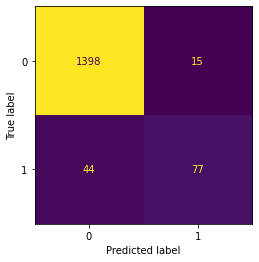

In [217]:
plot_confusion_matrix(rf,  X_test, y_test, colorbar=False)
plt.grid(False)

In [221]:
print('\n',classification_report(y_test, rf.predict(X_test)))


               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1413
           1       0.84      0.64      0.72       121

    accuracy                           0.96      1534
   macro avg       0.90      0.81      0.85      1534
weighted avg       0.96      0.96      0.96      1534



## Rolx Features

In [181]:
df_rolx_features.reset_index(inplace=True)
df_rolx_features.rename(columns={"index": "node"}, inplace=True)

In [182]:
df_rolx_features.head()

,node,degree(mean)(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean),degree(mean)(mean)(mean),external_edges(mean)(mean)(mean),internal_edges(mean)(mean)(mean),...,internal_edges(mean)(mean),degree(mean),degree(sum),external_edges(mean),external_edges(sum),internal_edges(mean),internal_edges(sum),degree,external_edges,internal_edges
0,0,122.911817,7031.575466,132.282348,7161.562752,126.666861,7007.144222,171.968253,7613.460850,1218.033682,...,796.024017,522.000000,1044.0,13388.000000,26776.0,3393.000000,6786.0,2,1040,3
1,1,117.451245,6887.160205,127.834668,7069.735537,108.328023,6606.690605,137.216901,7124.999997,1118.709990,...,634.025197,160.777778,1447.0,7147.444444,64327.0,1335.111111,12016.0,9,1430,13
2,2,113.661413,6905.925289,144.803249,7465.488015,104.716202,6701.192091,180.449038,7868.899871,1310.129894,...,669.506174,230.875000,1847.0,7066.750000,56534.0,1375.875000,11007.0,8,1831,12
3,3,115.806022,6963.119542,132.071738,7315.552365,107.097952,6910.196859,152.362408,7981.788553,1243.196963,...,698.164599,246.541667,5917.0,11846.208333,284309.0,2131.750000,51162.0,24,5739,101
4,4,131.315295,7268.699390,109.250859,6890.940159,142.528488,7518.393904,94.558898,6709.813626,741.800976,...,1027.830011,75.968750,2431.0,6181.906250,197821.0,616.687500,19734.0,32,2301,81


In [183]:
merged_rolx = pd.merge(df_rolx_features, df2, left_on='node', right_on='new_id', how='left').drop("new_id", axis=1)
merged_rolx.head()

,node,degree(mean)(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean),degree(mean)(mean)(mean),external_edges(mean)(mean)(mean),internal_edges(mean)(mean)(mean),...,internal_edges(sum),degree,external_edges,internal_edges,id,days,mature,views,partner,target
0,0,122.911817,7031.575466,132.282348,7161.562752,126.666861,7007.144222,171.968253,7613.460850,1218.033682,...,6786.0,2,1040,3,81715208,1347,False,1925,False,0
1,1,117.451245,6887.160205,127.834668,7069.735537,108.328023,6606.690605,137.216901,7124.999997,1118.709990,...,12016.0,9,1430,13,61235209,1637,False,2350,False,0
2,2,113.661413,6905.925289,144.803249,7465.488015,104.716202,6701.192091,180.449038,7868.899871,1310.129894,...,11007.0,8,1831,12,161054730,477,False,996,False,0
3,3,115.806022,6963.119542,132.071738,7315.552365,107.097952,6910.196859,152.362408,7981.788553,1243.196963,...,51162.0,24,5739,101,134176781,761,False,4469,False,0
4,4,131.315295,7268.699390,109.250859,6890.940159,142.528488,7518.393904,94.558898,6709.813626,741.800976,...,19734.0,32,2301,81,107339790,1060,False,215460,True,1


In [184]:
merged_rolx.drop("views",inplace=True, axis=1)
merged_rolx.head()

,node,degree(mean)(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean),degree(mean)(mean)(mean),external_edges(mean)(mean)(mean),internal_edges(mean)(mean)(mean),...,internal_edges(mean),internal_edges(sum),degree,external_edges,internal_edges,id,days,mature,partner,target
0,0,122.911817,7031.575466,132.282348,7161.562752,126.666861,7007.144222,171.968253,7613.460850,1218.033682,...,3393.000000,6786.0,2,1040,3,81715208,1347,False,False,0
1,1,117.451245,6887.160205,127.834668,7069.735537,108.328023,6606.690605,137.216901,7124.999997,1118.709990,...,1335.111111,12016.0,9,1430,13,61235209,1637,False,False,0
2,2,113.661413,6905.925289,144.803249,7465.488015,104.716202,6701.192091,180.449038,7868.899871,1310.129894,...,1375.875000,11007.0,8,1831,12,161054730,477,False,False,0
3,3,115.806022,6963.119542,132.071738,7315.552365,107.097952,6910.196859,152.362408,7981.788553,1243.196963,...,2131.750000,51162.0,24,5739,101,134176781,761,False,False,0
4,4,131.315295,7268.699390,109.250859,6890.940159,142.528488,7518.393904,94.558898,6709.813626,741.800976,...,616.687500,19734.0,32,2301,81,107339790,1060,False,True,1


In [192]:
X = merged_rolx.drop("target", axis=1)
y = merged_rolx.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)

In [193]:
y.value_counts()

0    4280
1     368
Name: target, dtype: int64

### Logistic Regression

In [194]:
logreg_rolx = LogisticRegression(random_state=42)
logreg_rolx.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [195]:
y_pred_rolx = logreg_rolx.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rolx))
print("F1 score:", f1_score(y_test, y_pred_rolx, average='weighted'))

Accuracy: 0.9517601043024772
F1 score: 0.9481041611582681


### Random Forest Classifier

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)
rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20, n_estimators=300, min_samples_leaf=2, min_samples_split=2, criterion='gini')
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print(f1_score(y_test, y_pred_test, average='weighted'))
print(accuracy_score(y_test, y_pred_test))

0.9577180353925261
0.9595827900912647


## All Features

In [197]:
df_target = pd.read_csv("musae_ES_target.csv")
df_target.head()

,id,days,mature,views,partner,new_id
0,68458707,1522,False,4405,False,3558
1,133928858,768,False,164810,True,3372
2,46892468,1895,False,4953,False,818
3,128745923,828,True,12262,False,236
4,84422595,1317,False,4937,False,2255


In [198]:
df_n2v.head()

,node,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,-0.038693,0.061539,-0.054123,0.108531,0.082604,0.013199,0.693135,0.822040,0.337492,...,0.508554,-0.548458,-0.920315,-0.316865,0.209545,0.205136,0.236856,0.183324,-0.473698,0.110939
1,1819,0.021252,-0.048278,0.307998,0.082019,0.237442,-0.169190,0.879707,0.337308,0.037778,...,0.354485,-0.300931,-0.267196,-0.403600,0.223628,0.014998,0.238747,-0.052691,-0.313206,-0.322988
2,2840,-0.050995,-0.099610,-0.119920,0.203510,0.119797,0.019115,0.521396,0.794796,0.120367,...,0.443432,-0.600783,-0.487771,-0.208593,0.337861,0.397761,0.023262,0.153684,-0.291841,-0.012149
3,1,-0.288346,-0.116251,0.518327,-0.502320,0.014213,-0.713407,0.025140,0.863544,0.226216,...,0.626956,-0.681756,-0.499925,1.295646,-0.506894,0.335549,0.570367,-0.813523,-0.272436,0.134440
4,1565,0.397726,-0.005229,0.224576,0.115542,0.294123,0.156943,0.317848,0.466120,0.207030,...,0.241921,0.043532,0.214276,0.574723,0.245252,0.404123,0.601845,-0.236635,-0.417112,0.303176


In [199]:
node_embeddings_ = pd.merge(df_n2v, df_target, left_on='node', right_on='new_id', how='left').drop("new_id", axis=1)
node_embeddings_.head()

,node,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,id,days,mature,views,partner
0,0,-0.038693,0.061539,-0.054123,0.108531,0.082604,0.013199,0.693135,0.822040,0.337492,...,0.205136,0.236856,0.183324,-0.473698,0.110939,81715208,1347,False,1925,False
1,1819,0.021252,-0.048278,0.307998,0.082019,0.237442,-0.169190,0.879707,0.337308,0.037778,...,0.014998,0.238747,-0.052691,-0.313206,-0.322988,36138196,2221,False,18196139,True
2,2840,-0.050995,-0.099610,-0.119920,0.203510,0.119797,0.019115,0.521396,0.794796,0.120367,...,0.397761,0.023262,0.153684,-0.291841,-0.012149,38155229,2138,False,3555,False
3,1,-0.288346,-0.116251,0.518327,-0.502320,0.014213,-0.713407,0.025140,0.863544,0.226216,...,0.335549,0.570367,-0.813523,-0.272436,0.134440,61235209,1637,False,2350,False
4,1565,0.397726,-0.005229,0.224576,0.115542,0.294123,0.156943,0.317848,0.466120,0.207030,...,0.404123,0.601845,-0.236635,-0.417112,0.303176,47939440,1877,False,9362112,True


In [200]:
all_df = pd.merge(merged_rolx,df_n2v , left_on='node', right_on='node', how='left')
all_df.head()

,node,degree(mean)(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean)(mean),degree(mean)(mean)(mean)(mean),external_edges(mean)(mean)(mean)(mean),degree(mean)(mean)(mean),external_edges(mean)(mean)(mean),internal_edges(mean)(mean)(mean),...,10,11,12,13,14,15,16,17,18,19
0,0,122.911817,7031.575466,132.282348,7161.562752,126.666861,7007.144222,171.968253,7613.460850,1218.033682,...,0.508554,-0.548458,-0.920315,-0.316865,0.209545,0.205136,0.236856,0.183324,-0.473698,0.110939
1,1,117.451245,6887.160205,127.834668,7069.735537,108.328023,6606.690605,137.216901,7124.999997,1118.709990,...,0.626956,-0.681756,-0.499925,1.295646,-0.506894,0.335549,0.570367,-0.813523,-0.272436,0.134440
2,2,113.661413,6905.925289,144.803249,7465.488015,104.716202,6701.192091,180.449038,7868.899871,1310.129894,...,-0.300764,-0.343455,-0.386205,0.180286,0.488573,0.388220,-0.038499,0.444397,-0.858727,0.068094
3,3,115.806022,6963.119542,132.071738,7315.552365,107.097952,6910.196859,152.362408,7981.788553,1243.196963,...,0.211812,-0.514536,0.329305,-0.226169,0.149725,-0.073680,0.403695,-0.203362,-0.199615,-0.459039
4,4,131.315295,7268.699390,109.250859,6890.940159,142.528488,7518.393904,94.558898,6709.813626,741.800976,...,0.067359,-0.493697,0.082775,-0.862780,-0.296361,0.894713,0.187954,-0.911491,-0.285367,-0.015349


In [106]:
all_df.columns

Index([                                              'node',
               'degree(mean)(mean)(mean)(mean)(mean)(mean)',
       'external_edges(mean)(mean)(mean)(mean)(mean)(mean)',
                     'degree(mean)(mean)(mean)(mean)(mean)',
             'external_edges(mean)(mean)(mean)(mean)(mean)',
                           'degree(mean)(mean)(mean)(mean)',
                   'external_edges(mean)(mean)(mean)(mean)',
                                 'degree(mean)(mean)(mean)',
                         'external_edges(mean)(mean)(mean)',
                         'internal_edges(mean)(mean)(mean)',
                                       'degree(mean)(mean)',
                               'external_edges(mean)(mean)',
                               'internal_edges(mean)(mean)',
                                             'degree(mean)',
                                              'degree(sum)',
                                     'external_edges(mean)',
                        

In [201]:
logreg_all = LogisticRegression(random_state=42)
logreg_all.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [202]:
y_pred_all = logreg_all.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_all))
print("F1 score:", f1_score(y_test, y_pred_all, average='weighted'))

Accuracy: 0.9517601043024772
F1 score: 0.9481041611582681


In [203]:
X = all_df.drop(columns=["target"], axis=1)
y = all_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)

## Random Forest

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)
rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20, n_estimators=300, min_samples_leaf=2, min_samples_split=2, criterion='gini')
rf.fit(X_train, y_train)
y_pred_test_emb = rf.predict(X_test)
print(f1_score(y_test, y_pred_test_emb, average='weighted'))
print(accuracy_score(y_test, y_pred_test_emb))

0.9591155266052284
0.9615384615384616


## Community Detection

In [112]:
conda install python-louvain

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - python-louvain


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.12.0               |   py39hecd8cb5_0        14.5 MB
    python-louvain-0.15        |     pyhd3eb1b0_0          13 KB
    ------------------------------------------------------------
                                           Total:        14.5 MB

The following NEW packages will be INSTALLED:

  python-louvain     pkgs/main/noarch::python-louvain-0.15-pyhd3eb1b0_0

The following packages will be UPDATED:

  conda                               4.10.3-py39hecd8cb5_0 --> 4.12.0-py39hecd8cb5_0



python-louvain-0.15  | 13 KB     | ##################################### | 100% 
conda-4.12.0         | 14.5 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transactio

In [114]:
commLouvain = community_louvain.best_partition(G)
print(f"Communities via Modularity Max:\n{commLouvain}")

Communities via Modularity Max:
{0: 0, 1819: 0, 2840: 0, 1: 1, 1565: 1, 1309: 2, 1397: 1, 2677: 2, 3497: 1, 357: 1, 1492: 1, 4125: 3, 1351: 3, 2: 0, 1437: 0, 1728: 0, 214: 0, 485: 0, 2753: 0, 676: 0, 3719: 0, 3: 3, 3830: 3, 2504: 4, 3387: 2, 4528: 4, 246: 3, 1266: 3, 982: 0, 596: 0, 291: 3, 2480: 3, 1676: 3, 1450: 3, 79: 3, 2112: 1, 222: 3, 2558: 3, 574: 3, 1376: 2, 2306: 3, 4642: 0, 1988: 3, 2922: 2, 896: 3, 4: 3, 2213: 3, 7: 3, 1169: 3, 963: 3, 2647: 3, 2182: 3, 1011: 3, 1264: 3, 3984: 4, 483: 3, 4397: 3, 1480: 0, 3767: 3, 1447: 3, 2771: 3, 3737: 3, 1451: 0, 1827: 3, 4423: 3, 1121: 3, 2414: 3, 4217: 0, 1067: 0, 3675: 3, 1513: 0, 4121: 3, 1083: 3, 2853: 3, 793: 3, 549: 0, 3159: 3, 5: 1, 3655: 1, 3022: 1, 570: 1, 2348: 1, 2273: 1, 4001: 1, 4228: 1, 3762: 1, 2483: 0, 111: 1, 3915: 1, 140: 1, 3128: 1, 1832: 1, 4569: 1, 1604: 1, 531: 1, 6: 1, 1047: 1, 2280: 1, 8: 0, 3235: 3, 4162: 0, 2864: 0, 4245: 0, 2891: 3, 755: 0, 10: 0, 2574: 0, 1857: 2, 781: 0, 1873: 2, 1084: 0, 11: 0, 4142: 2, 406:

In [115]:
comm_mod_max = dict()
for nodeid, partition in commLouvain.items():
    if partition in comm_mod_max:
        comm_mod_max[partition].append(nodeid)
    else:
        comm_mod_max[partition] = [nodeid]

In [116]:
comm_mod_max

{0: [0,
  1819,
  2840,
  2,
  1437,
  1728,
  214,
  485,
  2753,
  676,
  3719,
  982,
  596,
  4642,
  1480,
  1451,
  4217,
  1067,
  1513,
  549,
  2483,
  8,
  4162,
  2864,
  4245,
  755,
  10,
  2574,
  781,
  1084,
  11,
  406,
  2847,
  2953,
  4258,
  2375,
  1005,
  743,
  16,
  4070,
  1152,
  18,
  1515,
  2804,
  1093,
  3572,
  1381,
  1391,
  667,
  679,
  2999,
  3220,
  1440,
  1341,
  2955,
  1938,
  1129,
  1749,
  2019,
  1800,
  1206,
  1310,
  855,
  23,
  1789,
  811,
  4382,
  1687,
  2294,
  24,
  3871,
  25,
  264,
  3807,
  4010,
  1849,
  4449,
  520,
  4219,
  2124,
  277,
  1178,
  2664,
  4467,
  3998,
  2165,
  3738,
  1156,
  1478,
  2666,
  1115,
  3614,
  4477,
  3020,
  3203,
  3478,
  4080,
  2423,
  1720,
  4309,
  940,
  966,
  2228,
  3749,
  1220,
  1431,
  776,
  2210,
  2295,
  1352,
  924,
  2074,
  2235,
  2325,
  2562,
  34,
  1694,
  2936,
  4412,
  2879,
  1183,
  1762,
  1061,
  46,
  1366,
  3066,
  3296,
  831,
  492,
  50,
  3201,
 

In [118]:
lovModularity = community_louvain.modularity(commLouvain, G)
print("Modularity of Twitch Communities found via Louvain: {0:.5f}".format(lovModularity))

Modularity of Twitch Communities found via Louvain: 0.40631


In [132]:
#compute the best partition
partition = community_louvain.best_partition(G, weight="None", random_state=42)

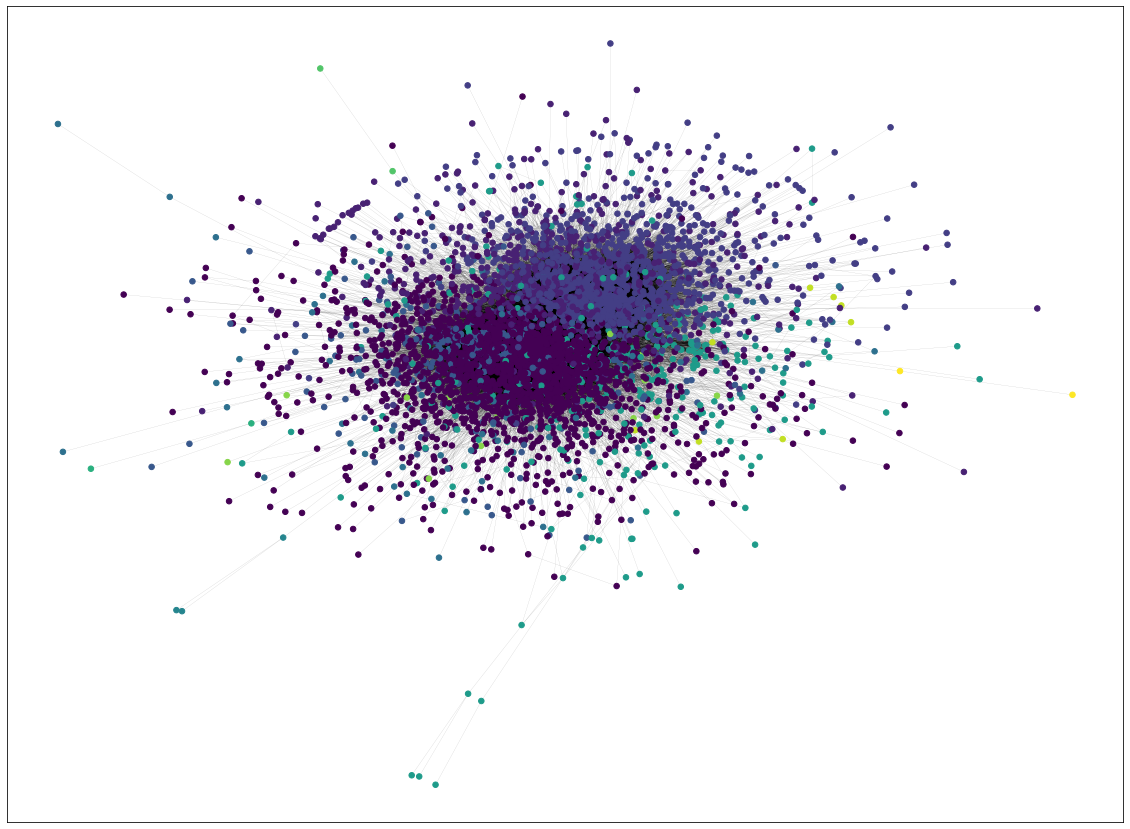

In [143]:
# draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(20, 15))
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=30,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.1)
plt.show()

In [157]:
print("Number of Communities:",len(set(partition.values())))

Number of Communities: 6


In [222]:
# compute modularity scores for Girvan-Newman partitions
communitiesGM = girvan_newman(G)
firstcomm = next(communitiesGM)
seccomm = next(communitiesGM)
thirdcomm = next(communitiesGM)
fourthcomm = next(communitiesGM)
fifthcomm = next(communitiesGM)
sixthcomm = next(communitiesGM)

In [ ]:
print(len(firstcomm))
print("1st", firstcomm)
print(len(seccomm))
print("second",seccomm)
print(len(thirdcomm))
print("third",thirdcomm)
print(len(fourthcomm))
print("fourth",fourthcomm)
print(len(fifthcomm))
print("fifth",fifthcomm)
print(len(sixthcomm))
print("sixth",sixthcomm)

2
1st ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [228]:
### compute the modularity of girvan newman community of 2 communities ###
# converts from partition:nodeset to dictionary of nodeid:partitionid 
i = 0
comm4mod = dict()
for comm in firstcomm:
    for node in comm:
        comm4mod[node] = i
    i += 1
print(comm4mod)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

In [229]:
girvannewmanModularity = community_louvain.modularity(comm4mod, G)

In [230]:
print(f"Modularity of Twitch Communities (num comm:{len(firstcomm)}) found via GirvanNewman: {girvannewmanModularity:.5f}")

Modularity of Twitch Communities (num comm:2) found via GirvanNewman: 0.00007


In [231]:
# compute the modularity of girvan newman community of 3 communities
i = 0
comm4mod = dict()
for comm in seccomm:
    for node in comm:
        comm4mod[node] = i
    i += 1
print(comm4mod)
girvannewmanModularity = community_louvain.modularity(comm4mod, G)


{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

In [232]:
print(f"Modularity of Twitch Communities (num comm:{len(seccomm)}) found via GirvanNewman: {girvannewmanModularity:.5f}")

Modularity of Twitch Communities (num comm:3) found via GirvanNewman: 0.00013


In [233]:
# compute the modularity of girvan newman community of 4 communities
i = 0
comm4mod = dict()
for comm in thirdcomm:
    for node in comm:
        comm4mod[node] = i
    i += 1
print(comm4mod)
girvannewmanModularity = community_louvain.modularity(comm4mod, G)
print(f"Modularity of Twitch Communities (num comm:{len(thirdcomm)}) found via GirvanNewman: {girvannewmanModularity:.5f}")

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

In [234]:
# compute the modularity of girvan newman community of 5 communities
i = 0
comm4mod = dict()
for comm in fourthcomm:
    for node in comm:
        comm4mod[node] = i
    i += 1
print(comm4mod)
girvannewmanModularity = community_louvain.modularity(comm4mod, G)
print(f"Modularity of Twitch Communities (num comm:{len(fourthcomm)}) found via GirvanNewman: {girvannewmanModularity:.5f}")

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

In [236]:
# compute the modularity of girvan newman community of 6 communities
i = 0
comm4mod = dict()
for comm in fifthcomm:
    for node in comm:
        comm4mod[node] = i
    i += 1
print(comm4mod)
girvannewmanModularity = community_louvain.modularity(comm4mod, G)
print(f"Modularity of Twitch Communities (num comm:{len(fifthcomm)}) found via GirvanNewman: {girvannewmanModularity:.5f}")

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

In [235]:
# compute the modularity of girvan newman community of 7 communities
i = 0
comm4mod = dict()
for comm in sixthcomm:
    for node in comm:
        comm4mod[node] = i
    i += 1
print(comm4mod)
girvannewmanModularity = community_louvain.modularity(comm4mod, G)
print(f"Modularity of Twitch Communities (num comm:{len(sixthcomm)}) found via GirvanNewman: {girvannewmanModularity:.5f}")

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 